# Fraud Detector - Batch Prediction API Example 
#### Supervised fraud detection  
-------

## Setup
------
First setup your AWS credentials so that Fraud Detector can store and access training data and supporting detector artifacts.

https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own.

We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.

## Plan
------

You'll need the following pieces of information to make predictions on your dataset. 

- ENTITY_TYPE  
- EVENT_TYPE    
- DETECTOR_NAME & VERSION


You'll also need to identify how many records you'd like to predict on.  


In [16]:
# # Upgrade boto3 to the latest version

# !pip install -U boto3

In [2]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
np.seterr(divide='ignore', invalid='ignore')


import pandas as pd
import uuid 
from datetime import datetime
from io import StringIO # python3; python2: BytesIO 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# -- dask for parallelism -- 
import dask 

# -- standard stuff -- 
import time
from datetime import datetime

# -- AWS stuff -- 
import boto3

%matplotlib inline

In [3]:
boto3.__version__

'1.17.47'

## Initialize AWS Fraud Detector Client 
------

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html 


In [18]:
# -- fraud detector client --
client = boto3.client('frauddetector',)
s3_client = boto3.client('s3')

# -- use this to append to files 
sufx   = datetime.now().strftime("%Y%m%d")

### Entity, Detector, Model, and File Information  
-----
<div class="alert alert-info"> 💡 <strong> Entity, Detector, and Files. </strong>

- DETECTOR_NAME & VERSION corresponds to the name and version of your deployed Fraud Detector  
- MODEL_NAME & VERSION corresponds to the name and version of the model deployed with your Fraud Detector   
- S3_BUCKET & S3_FILE this is the information on the S3 file you wish to apply your detector to.   

</div>

In [37]:
ENTITY_TYPE    = "your_entity_type"
EVENT_TYPE     = "your_event_type" 

DETECTOR_NAME = "your_detector_name"
DETECTOR_VER  = "your_detector_version"

# -- name and version of model, used to get the model column names -- 
MODEL_NAME    = "your_model_name"
MODEL_VER     = "your_model_version"

# s3://afd-training-data/schwab_sample_prep.csv

# -- input file of data to be scored -- 
ARN_ROLE      = "your_iam_arn_role" 
S3_BUCKET     = "your_bucket_name"
S3_FILE       = "your_prediction_file.csv"
S3_FILE_LOC   = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

# -- run 5000 records, you can change this here or below to run the whole file.
record_count = 5000

#### Load Data to be Scored 
-----
<div class="alert alert-info"> 💡 <strong> Check the first 5 Records. </strong>

Does your data look correct? Do you need to rename any columns? You want the column names to match the field names used by the Model. 

</div>

In [40]:
# -- connect to S3, snag file, and convert to a panda's dataframe --
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE)
body = obj.get()['Body']
df   = pd.read_csv(body)
print(df.shape)
df.head()

(5000, 11)


,ip_address,email_address,user_agent,customer_city,customer_state,customer_postal,EVENT_TIMESTAMP,customer_name,customer_address,phone_number,EVENT_LABEL
0,84.138.6.238,synth_tmorton@yahoo.com,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,Meganstad,LA,32733.0,2020-04-11 17:27:38,Brandon Moran,824 Price Bypass,(555)784 - 5238,0
1,194.147.250.63,synth_oscott@yahoo.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,Christinaport,MN,34319.0,2020-04-11 17:31:12,Dominic Murray,13515 Ashley Haven Apt. 472,(555)114 - 6133,0
2,192.54.60.50,synth_aoliver@gmail.com,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,Donaldfurt,WA,32436.0,2020-04-11 17:46:34,Anthony Abbott,039 Amy Glens,(555)780 - 7652,0
3,169.120.193.154,synth_clewis@gmail.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,Williamburgh,AL,34399.0,2020-04-11 17:48:52,Kimberly Webb,81397 Tom Forge,(555)588 - 4426,0
4,192.175.55.43,synth_katherinedavis@hotmail.com,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,East Markland,IL,33690.0,2020-04-11 17:49:23,Renee James,6815 Dawson Estate,(555)785 - 8274,0


## Run  Batch Predictions  
-----
The following runs batch prediction on your test dataset.

https://docs.aws.amazon.com/frauddetector/latest/ug/batch-predictions.html

In [41]:
def get_event_variables(EVENT_TYPE):
    """ return list of variables used by a model 
    
    """
    response = client.get_event_types(name=EVENT_TYPE)
    event_variables = []

    for v in response['eventTypes'][0]['eventVariables']:
        event_variables.append(v)
    return event_variables

event_variables = get_event_variables(EVENT_TYPE)
print("\n -- event variables -- ")
print(event_variables)


 -- event variables -- 
['ip_address', 'email_address', 'user_agent', 'customer_city', 'customer_state', 'customer_postal', 'customer_name', 'customer_address', 'phone_number']


#### Prepare Test Data
-----
<div class="alert alert-info"> 💡 <strong> Add/Modify columns if needed. </strong>

Does your data have columus of ENTITY_TYPE, ENTITY_ID and EVENT_ID? If not, add these columns. 

</div>

<i> This particular dataset also has column EVENT_LABEL, we remove it since this is not expected for batch prediction jobs</i>

In [42]:
df_test = df.head(record_count).copy()

df_test["ENTITY_ID"] = "8" # we use a random number here, you can use anything that uniquely identifies an entity
df_test["EVENT_ID"] = [ str(x+1) for x in range(record_count) ]
df_test["ENTITY_TYPE"] = ENTITY_TYPE
df_test.drop(["EVENT_LABEL"], axis=1, inplace=True)
print(df_test.shape)
df_test.head()

(5000, 13)


,ip_address,email_address,user_agent,customer_city,customer_state,customer_postal,EVENT_TIMESTAMP,customer_name,customer_address,phone_number,ENTITY_ID,EVENT_ID,ENTITY_TYPE
0,84.138.6.238,synth_tmorton@yahoo.com,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,Meganstad,LA,32733.0,2020-04-11 17:27:38,Brandon Moran,824 Price Bypass,(555)784 - 5238,8,1,customer
1,194.147.250.63,synth_oscott@yahoo.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,Christinaport,MN,34319.0,2020-04-11 17:31:12,Dominic Murray,13515 Ashley Haven Apt. 472,(555)114 - 6133,8,2,customer
2,192.54.60.50,synth_aoliver@gmail.com,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,Donaldfurt,WA,32436.0,2020-04-11 17:46:34,Anthony Abbott,039 Amy Glens,(555)780 - 7652,8,3,customer
3,169.120.193.154,synth_clewis@gmail.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,Williamburgh,AL,34399.0,2020-04-11 17:48:52,Kimberly Webb,81397 Tom Forge,(555)588 - 4426,8,4,customer
4,192.175.55.43,synth_katherinedavis@hotmail.com,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,East Markland,IL,33690.0,2020-04-11 17:49:23,Renee James,6815 Dawson Estate,(555)785 - 8274,8,5,customer


#### Upload Test Data to S3
-----

In [43]:
INPUT_FILE = f"project_1_newaccounts_{record_count}_bp.csv"

csv_buffer = StringIO()
df_test.to_csv(csv_buffer, index=False)
s3.Object(S3_BUCKET, INPUT_FILE).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'DV95HYEVXPXYWJMQ',
  'HostId': 'ITx7is5ZYF07EyqclMdbpr4fnUvAJWTxoszDqS/iFdETNidHAzmTt9xMlN4kUFAgbBZhqeuYvu4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ITx7is5ZYF07EyqclMdbpr4fnUvAJWTxoszDqS/iFdETNidHAzmTt9xMlN4kUFAgbBZhqeuYvu4=',
   'x-amz-request-id': 'DV95HYEVXPXYWJMQ',
   'date': 'Mon, 19 Apr 2021 11:16:20 GMT',
   'etag': '"f3e7eb8f453943ab1b685e5a0eed8fc1"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"f3e7eb8f453943ab1b685e5a0eed8fc1"'}

#### Double Check on the Input CSV File
-----

<div class="alert alert-info"> 💡 <strong> Check schema </strong>

Does your test data looks as expected?. 

</div>

In [44]:
obj  = s3.Object(S3_BUCKET, INPUT_FILE)
body = obj.get()['Body']
df_input   = pd.read_csv(body, keep_default_na=False, na_values="", dtype=object)
print(df_input.shape)
df_input.head()

(5000, 13)


,ip_address,email_address,user_agent,customer_city,customer_state,customer_postal,EVENT_TIMESTAMP,customer_name,customer_address,phone_number,ENTITY_ID,EVENT_ID,ENTITY_TYPE
0,84.138.6.238,synth_tmorton@yahoo.com,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,Meganstad,LA,32733.0,2020-04-11 17:27:38,Brandon Moran,824 Price Bypass,(555)784 - 5238,8,1,customer
1,194.147.250.63,synth_oscott@yahoo.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,Christinaport,MN,34319.0,2020-04-11 17:31:12,Dominic Murray,13515 Ashley Haven Apt. 472,(555)114 - 6133,8,2,customer
2,192.54.60.50,synth_aoliver@gmail.com,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,Donaldfurt,WA,32436.0,2020-04-11 17:46:34,Anthony Abbott,039 Amy Glens,(555)780 - 7652,8,3,customer
3,169.120.193.154,synth_clewis@gmail.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,Williamburgh,AL,34399.0,2020-04-11 17:48:52,Kimberly Webb,81397 Tom Forge,(555)588 - 4426,8,4,customer
4,192.175.55.43,synth_katherinedavis@hotmail.com,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,East Markland,IL,33690.0,2020-04-11 17:49:23,Renee James,6815 Dawson Estate,(555)785 - 8274,8,5,customer


#### Create a Batch Prediction Job
-----

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html#FraudDetector.Client.create_batch_prediction_job

In [50]:
import random
import string
rdn_str = ''.join([random.choice(string.ascii_letters + string.digits) for n in range(6)])
rdn_str = rdn_str.lower()

job_id = 'batch_prediction_'+MODEL_NAME+"_"+rdn_str

print("-- creating batch prediction job --")
response = client.create_batch_prediction_job(
      jobId=job_id,
      inputPath="s3://{0}/{1}".format(S3_BUCKET,INPUT_FILE),
      outputPath="s3://{0}".format(S3_BUCKET),
      eventTypeName=EVENT_TYPE,
      detectorName=DETECTOR_NAME,
      detectorVersion=DETECTOR_VER,
      iamRoleArn=ARN_ROLE
)
print(response)

-- creating batch prediction job --
{'ResponseMetadata': {'RequestId': 'c22155c1-5651-429c-8568-5c806caa7be8', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 19 Apr 2021 11:20:42 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'c22155c1-5651-429c-8568-5c806caa7be8'}, 'RetryAttempts': 0}}


<div class="alert alert-info"> 💡 <strong> How to cancel Batch Prediction Job </strong>
    
Found something wrong and you don't want to wait?    

</div>

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html#FraudDetector.Client.cancel_batch_prediction_job


```python

response = client.cancel_batch_prediction_job(
      jobId=job_id
  )
print(response)

```

#### Check Status
-----

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html#FraudDetector.Client.get_batch_prediction_jobs

In [51]:
#-- wait until the batch prediction job is complete 
print("--- wait until the batch prediction job is complete ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_batch_prediction_jobs(
      jobId=job_id,
#       maxResults=123,
#       nextToken='string'
    )
    status = response['batchPredictions'][0]['status']
    if status != 'COMPLETE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if status == 'COMPLETE':
        print("Batch prediction status : " +  status)
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

Batch prediction status : COMPLETE
Elapsed time : 300.766459941864 seconds 

{'batchPredictions': [{'jobId': 'batch_prediction_project_1_model_xsa8al', 'status': 'COMPLETE', 'startTime': '2021-04-19T11:20:42Z', 'completionTime': '2021-04-19T11:26:41Z', 'lastHeartbeatTime': '2021-04-19T11:26:41Z', 'inputPath': 's3://mznzhen-hands-on-frauddetector/project_1_newaccounts_5000_bp.csv', 'outputPath': 's3://mznzhen-hands-on-frauddetector', 'eventTypeName': 'customer_registration', 'detectorName': 'project_1_detector', 'detectorVersion': '1', 'iamRoleArn': 'arn:aws:iam::602665643546:role/service-role/AmazonFraudDetector-DataAccessRole-1603121182197', 'arn': 'arn:aws:frauddetector:us-east-2:602665643546:batch-prediction/batch_prediction_project_1_model_xsa8al', 'processedRecordsCount': 5000, 'totalRecordsCount': 5000}], 'ResponseMetadata': {'RequestId': '9b58160e-4901-45ff-b7ce-9350cb3729b9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 19 Apr 2021 11:27:18 GMT', 'content-type': 'applic

#### Look at Output
-----

In [52]:
# The output file name starts with the job id
OUTPUT_FILE = s3_client.list_objects_v2(Bucket=S3_BUCKET, Prefix=job_id)['Contents'][0]['Key']
print(OUTPUT_FILE)

s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, OUTPUT_FILE)
body = obj.get()['Body']
df_output   = pd.read_csv(body, keep_default_na=False, na_values="", dtype=object)
print(df_output.shape)
df_output.head()

batch_prediction_project_1_model_xsa8al_1618831269_output.csv
(5000, 16)


,ip_address,email_address,user_agent,customer_city,customer_state,customer_postal,EVENT_TIMESTAMP,customer_name,customer_address,phone_number,ENTITY_ID,EVENT_ID,ENTITY_TYPE,MODEL_SCORES,OUTCOMES,STATUS
0,169.120.193.154,synth_clewis@gmail.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,Williamburgh,AL,34399.0,2020-04-11T17:48:52.000Z,Kimberly Webb,81397 Tom Forge,(555)588 - 4426,8,4,customer,{'project_1_model': 953.0},block,Success
1,192.175.55.43,synth_katherinedavis@hotmail.com,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,East Markland,IL,33690.0,2020-04-11T17:49:23.000Z,Renee James,6815 Dawson Estate,(555)785 - 8274,8,5,customer,{'project_1_model': 615.0},friction,Success
2,84.138.6.238,synth_tmorton@yahoo.com,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,Meganstad,LA,32733.0,2020-04-11T17:27:38.000Z,Brandon Moran,824 Price Bypass,(555)784 - 5238,8,1,customer,{'project_1_model': 14.0},approve,Success
3,192.54.60.50,synth_aoliver@gmail.com,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,Donaldfurt,WA,32436.0,2020-04-11T17:46:34.000Z,Anthony Abbott,039 Amy Glens,(555)780 - 7652,8,3,customer,{'project_1_model': 22.0},approve,Success
4,194.147.250.63,synth_oscott@yahoo.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,Christinaport,MN,34319.0,2020-04-11T17:31:12.000Z,Dominic Murray,13515 Ashley Haven Apt. 472,(555)114 - 6133,8,2,customer,{'project_1_model': 86.0},approve,Success


#### Delete Batch Prediction Job
-----

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html#FraudDetector.Client.delete_batch_prediction_job

In [53]:
response = client.delete_batch_prediction_job(
      jobId=job_id
  )
print(response)

{'ResponseMetadata': {'RequestId': 'f0119afe-21d0-44f7-a478-3f04b0e83806', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 19 Apr 2021 11:29:30 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'f0119afe-21d0-44f7-a478-3f04b0e83806'}, 'RetryAttempts': 0}}


### Take a look at your predictions
-----
Each record will have a score and the outcome of any rule conditions met. 

In [54]:
predictions = df_output.copy()
predictions['score'] = predictions['MODEL_SCORES'].str.slice(19,-1).astype(float)
predictions.drop(['MODEL_SCORES'], axis=1, inplace=True)
print(predictions.shape)
predictions.head()

(5000, 16)


,ip_address,email_address,user_agent,customer_city,customer_state,customer_postal,EVENT_TIMESTAMP,customer_name,customer_address,phone_number,ENTITY_ID,EVENT_ID,ENTITY_TYPE,OUTCOMES,STATUS,score
0,169.120.193.154,synth_clewis@gmail.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,Williamburgh,AL,34399.0,2020-04-11T17:48:52.000Z,Kimberly Webb,81397 Tom Forge,(555)588 - 4426,8,4,customer,block,Success,953.0
1,192.175.55.43,synth_katherinedavis@hotmail.com,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,East Markland,IL,33690.0,2020-04-11T17:49:23.000Z,Renee James,6815 Dawson Estate,(555)785 - 8274,8,5,customer,friction,Success,615.0
2,84.138.6.238,synth_tmorton@yahoo.com,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,Meganstad,LA,32733.0,2020-04-11T17:27:38.000Z,Brandon Moran,824 Price Bypass,(555)784 - 5238,8,1,customer,approve,Success,14.0
3,192.54.60.50,synth_aoliver@gmail.com,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,Donaldfurt,WA,32436.0,2020-04-11T17:46:34.000Z,Anthony Abbott,039 Amy Glens,(555)780 - 7652,8,3,customer,approve,Success,22.0
4,194.147.250.63,synth_oscott@yahoo.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,Christinaport,MN,34319.0,2020-04-11T17:31:12.000Z,Dominic Murray,13515 Ashley Haven Apt. 472,(555)114 - 6133,8,2,customer,approve,Success,86.0


### Make a Histogram of Scores 
-----
check out the distrirbution of scores. 

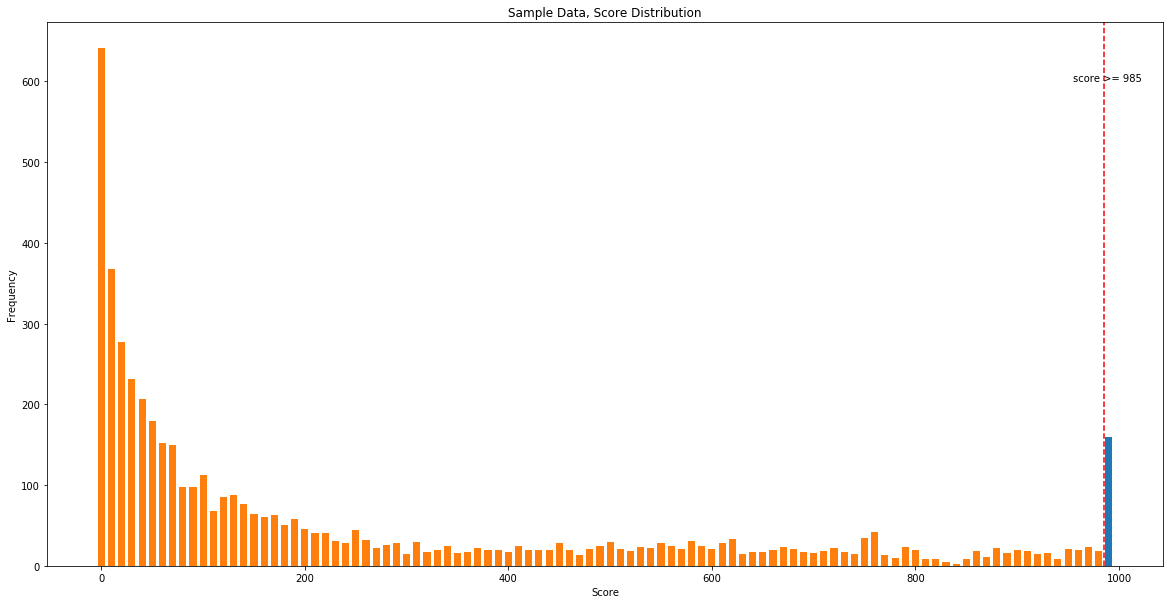

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions['score_bin'] = pd.cut(predictions['score'],100 ,labels= list(range(0,1000,10)))
predictions.loc[predictions['score'] >= 985, 'score_outcome'] = 'predicted fraud'
predictions.loc[predictions['score'] < 985, 'score_outcome'] = 'predicted legit'
ctab = pd.crosstab(predictions['score_bin'], predictions['score_outcome']).reset_index()

plt.figure(figsize=(20,10))
plt.bar(ctab['score_bin'], ctab['predicted fraud'], width=7)
plt.bar(ctab['score_bin'], ctab['predicted legit'], width=7)
plt.axvline(x=985, ls='--', C='red')
plt.title("Sample Data, Score Distribution")
plt.text( 955, 600, 'score >= 985')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### Take a look at your prediction outcomes
-----
see the potential impact from actions

In [57]:
predictions['OUTCOMES'] = predictions['OUTCOMES'].astype(str)
pred_summary = predictions.groupby(['OUTCOMES'])['score'].agg(['mean', 'count']).reset_index()
pred_summary['pct_total'] = pred_summary['count']/predictions.shape[0]
pred_summary

,OUTCOMES,mean,count,pct_total
0,approve,140.208333,4104,0.8208
1,block,987.755725,262,0.0524
2,friction,710.877895,475,0.0950
3,nan,NaN,0,0.0000
4,review,900.648276,145,0.0290


Confusion Matrix by Outcome


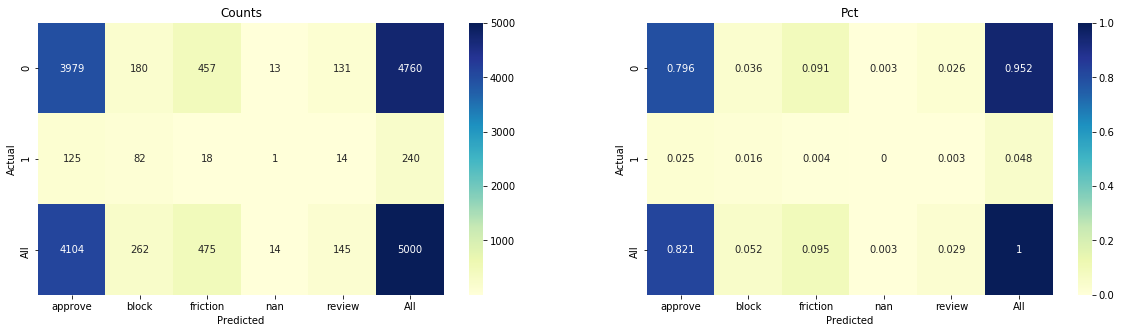

In [58]:
def model_confusion_matrix(predictions):
     
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    
    print("Confusion Matrix by Outcome")
    confusion_matrix = pd.crosstab(df['EVENT_LABEL'], predictions['OUTCOMES'].astype(str), margins=True, rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix_pct = pd.crosstab(df['EVENT_LABEL'], predictions['OUTCOMES'].astype(str), normalize="all", margins=True,rownames=['Actual'], colnames=['Predicted']).round(3)
    sns.heatmap(confusion_matrix, annot=True, fmt='g',cmap="YlGnBu", ax=ax1)
    sns.heatmap(confusion_matrix_pct, annot=True, fmt='g',cmap="YlGnBu", ax=ax2)
 
    ax1.title.set_text('Counts')
    ax2.title.set_text('Pct')

    
    plt.show()
    
    
model_confusion_matrix(predictions)

###  Write Predictions to File

-----
writing out predictions to a file allows you to analyze with other tools like QuickSight 

```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(FILE + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(FILE + ".xlsx", index=False)

```

In [ ]:
predictions.to_csv("project_1_5k_predictions.csv", index=False)